<a href="https://colab.research.google.com/github/MonitSharma/Learn-Quantum-Computing-with-Qiskit/blob/main/Quantum_Phase_Estimatoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-ibmq-provider
%pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=3f0dce994a063ab3bbb3f4dde63162f673e4832a2895963987882af89da63ebd
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


## Quantum Phase Estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:




Given a unitary operator $U$, the algorithm estimates $\theta$ in $U|\psi⟩ = e^{2 \pi \iota \theta} |\psi⟩$. Here $|\psi\rangle$ is an eigenvector and $e^{2 \pi \iota \theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

## Overview

The general quantum circuit for phase estimation is shown below. The top register contains $t$ 'counting' qubits, and the bottom contains qubits in the state : $|\psi⟩$



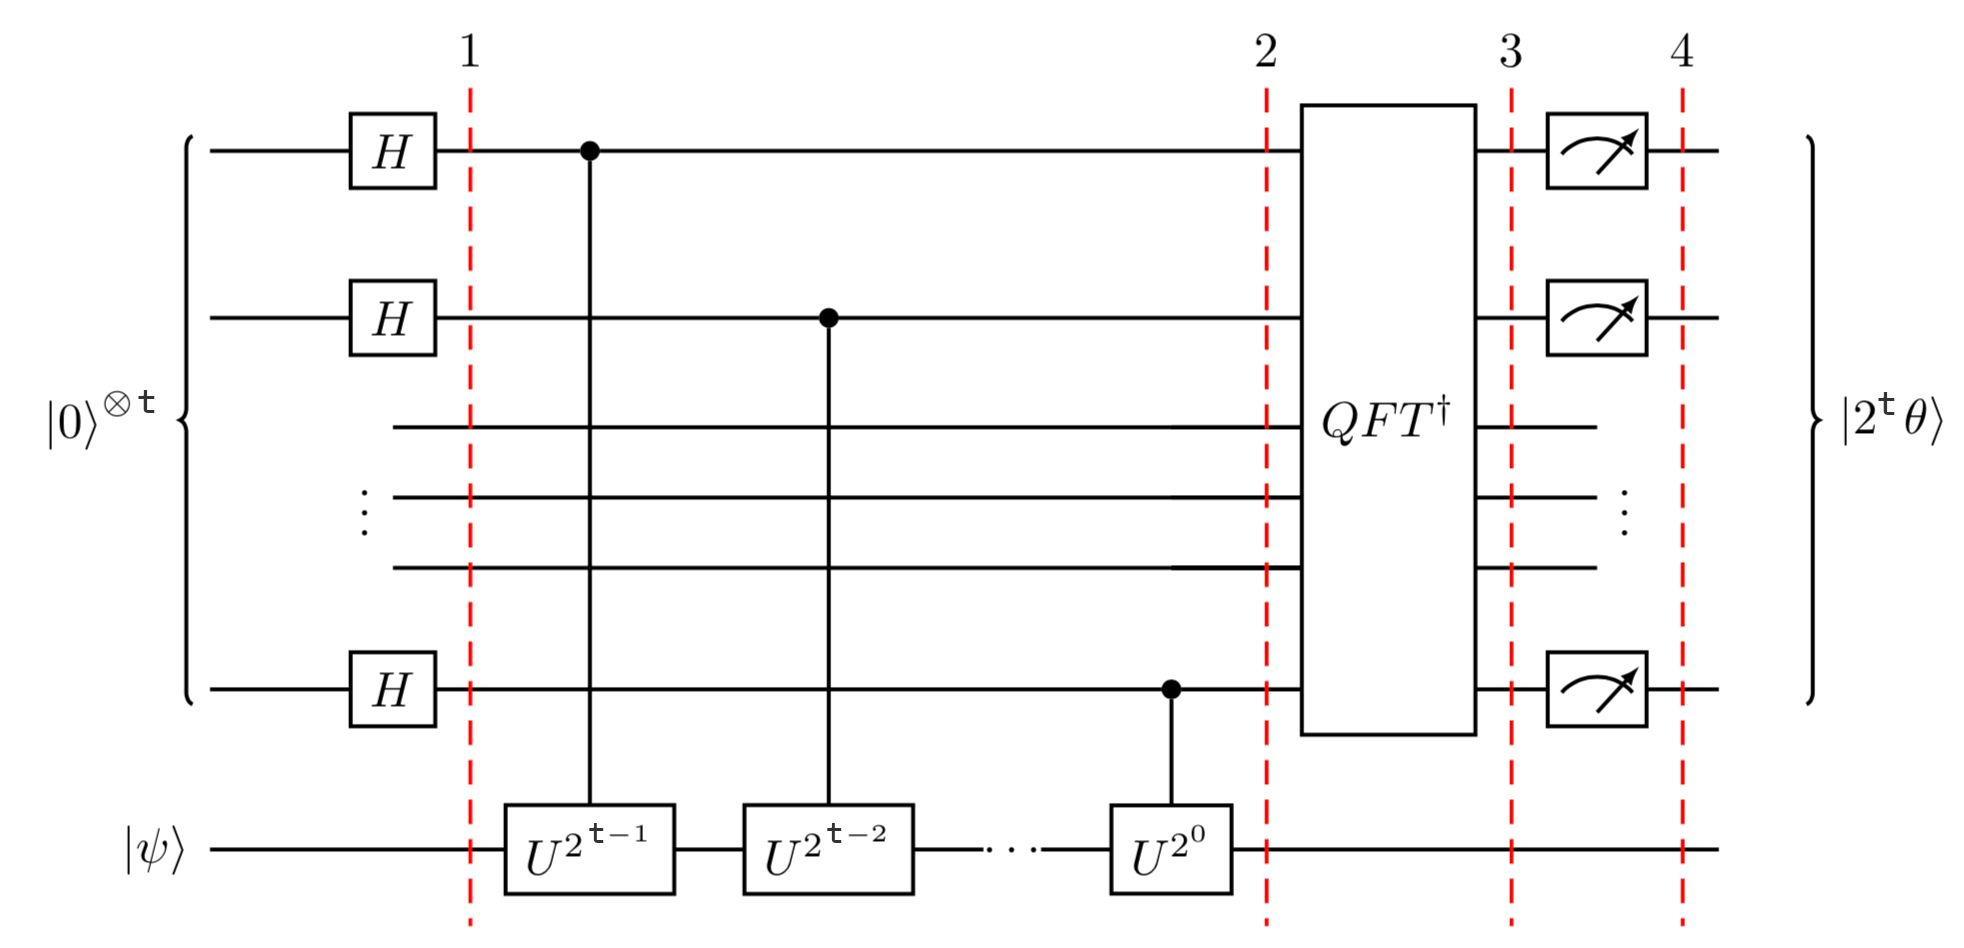



## Intuition

The quantum phase estimation algorithm uses phase kickback to write the phase of $U$(in the Fourier basis) to the $t$ qubits in the counting register. We then use the inverse QFT to translate this from the Fourier basis into the computational basis, which we can measure.

We remember (from the QFT chapter) that in the Fourier basis the topmost qubit completes one full rotation when counting between $0$ and $2^t$
. To count to a number,$x$ between $0$ and $2^t$
, we rotate this qubit by $x/2^t$
around the z-axis. For the next qubit we rotate by
$2x/2^t$, then $4x/2^t$
for the third qubit.

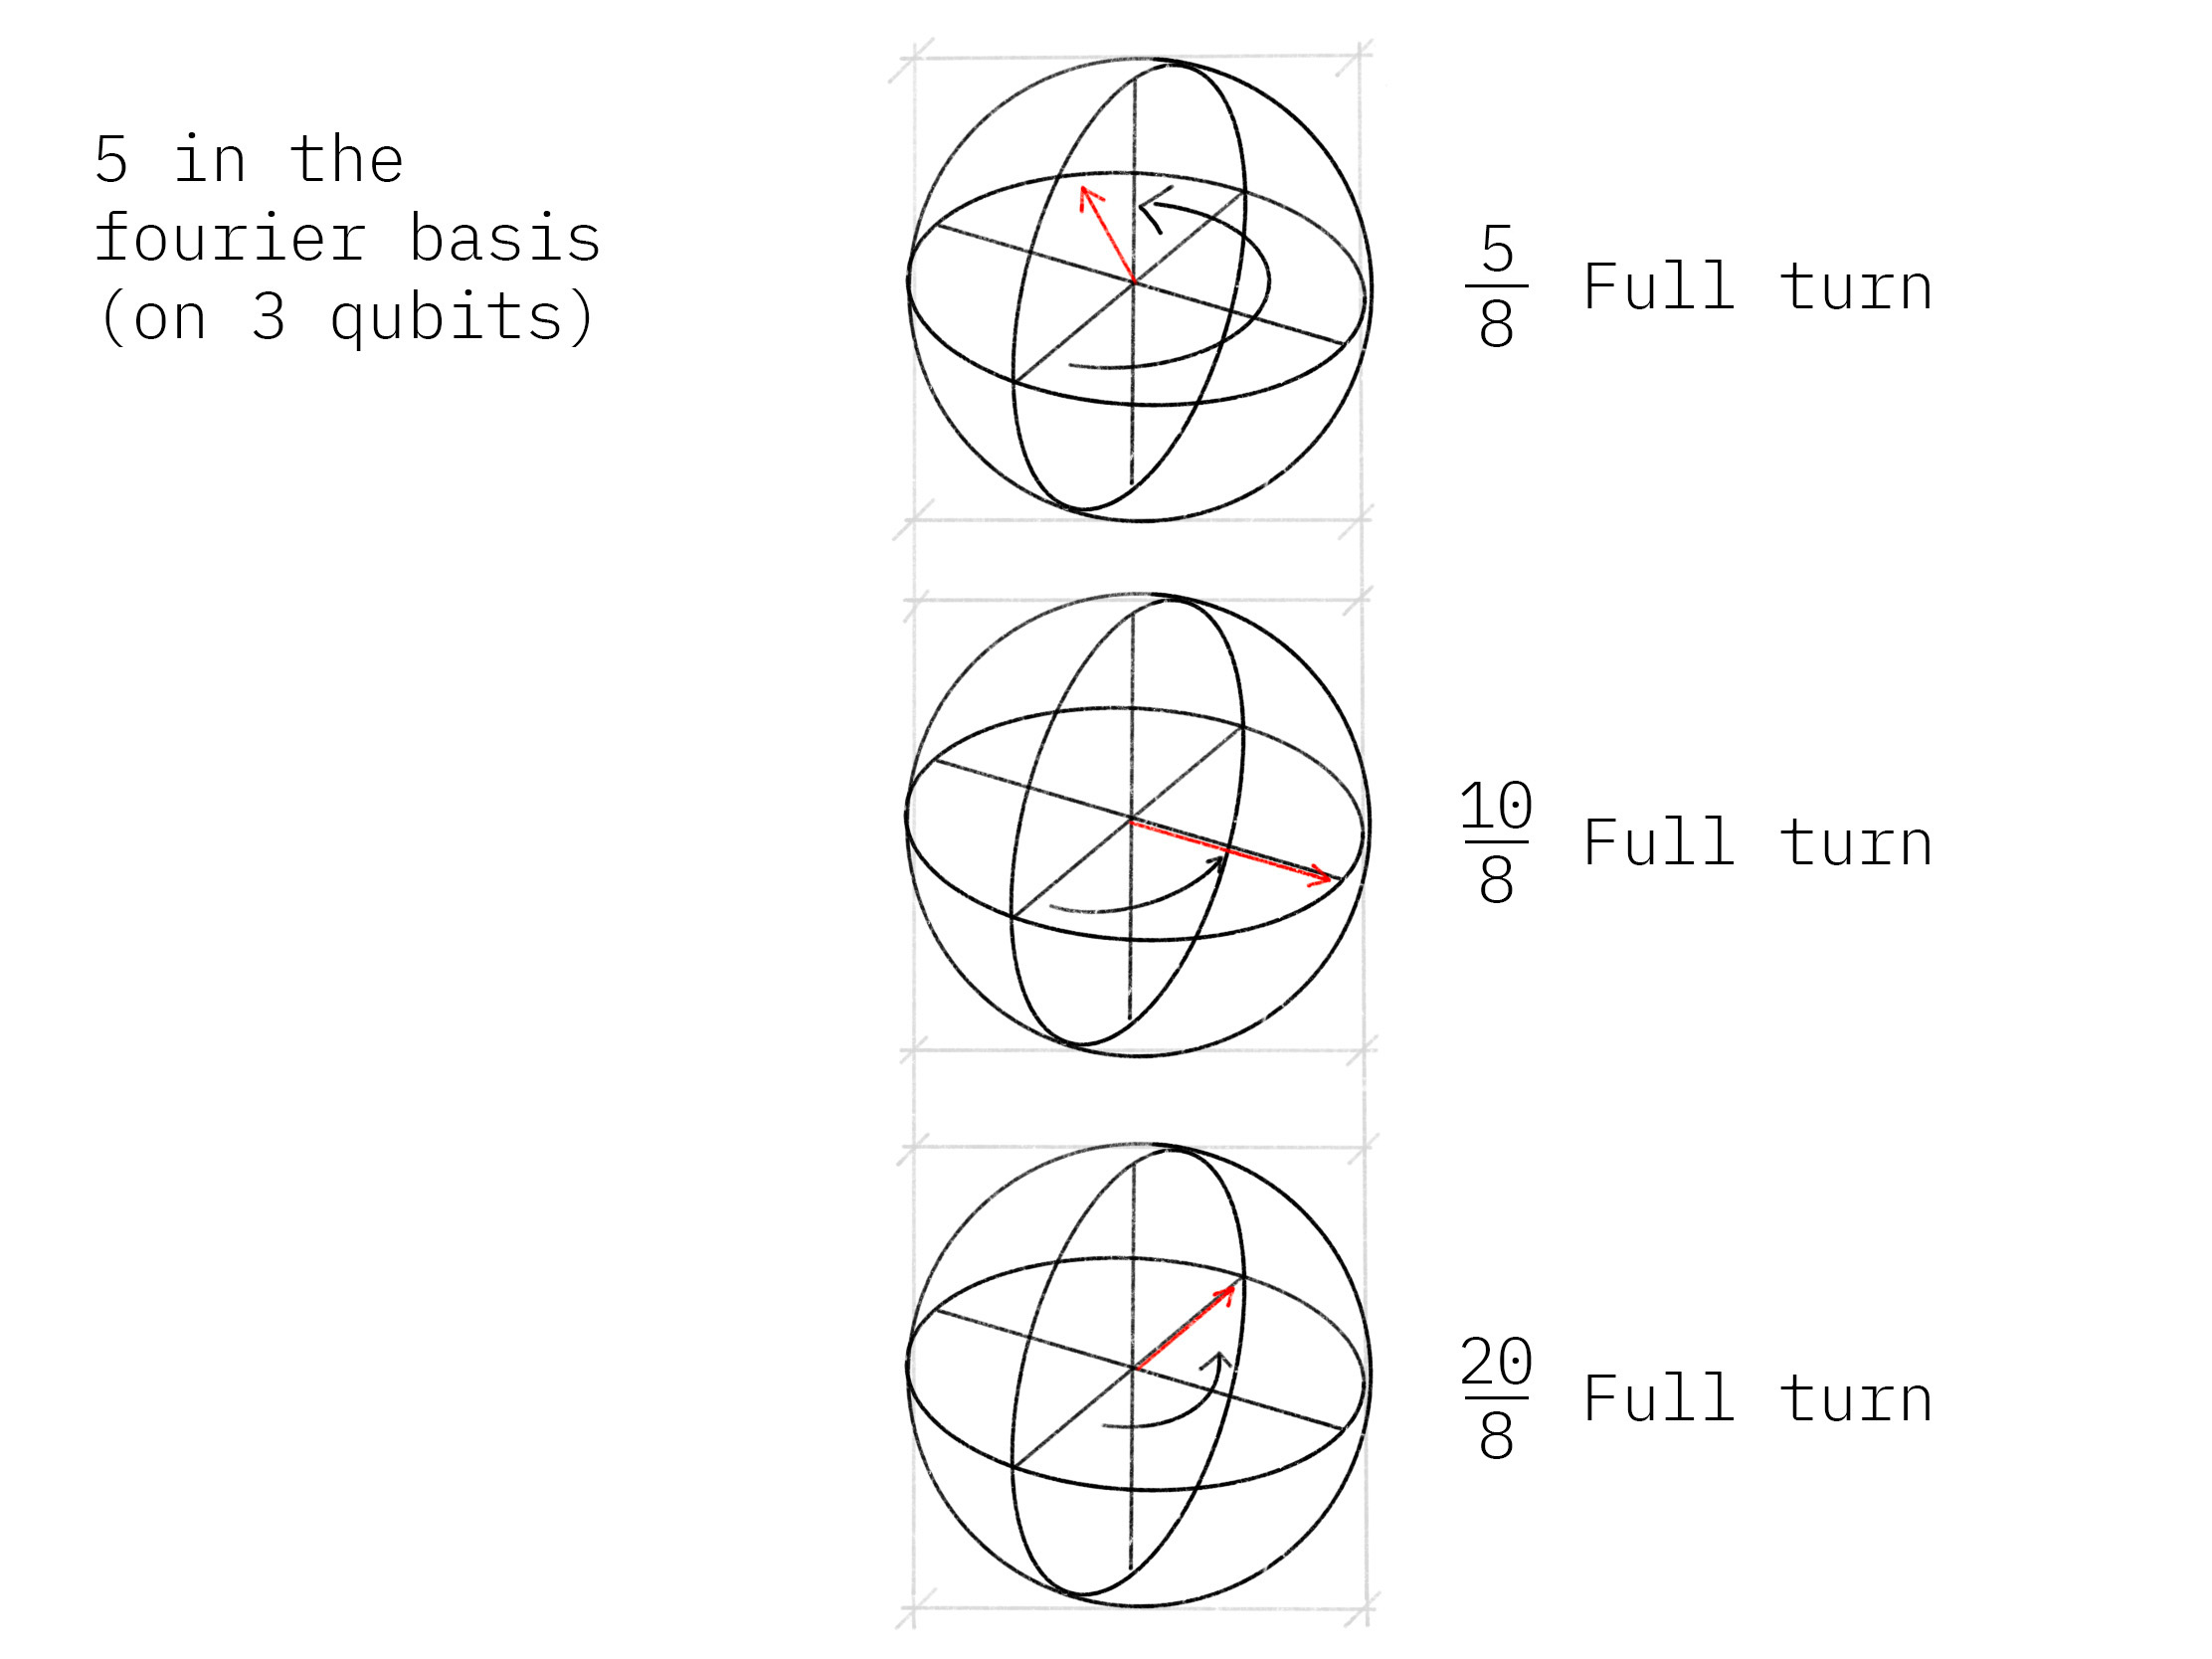

When we use a qubit to control the $U$-gate, the qubit will turn (due to kickback) proportionally to the phase $e^{2 \iota \pi \theta}$. We can use successive $CU$-gates to repeat this rotation an appropriate number of times until we have encoded the phase theta as a number between $0$ and $2^t$
in the Fourier basis.

Then we simply use $QFT^{\dagger}$
to convert this into the computational basis.

##  Mathematical Foundation

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U|\psi⟩ = e^{2 \pi \iota \theta}$, where$ |\psi⟩$ is an eigenvector and $e^{2 \pi \iota \theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

Setup:$|\psi⟩$ is in one set of qubit registers. An additional set of n qubits form the counting register on which we will store the value $2^n Θ$
:

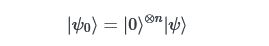


Superposition: Apply a n-bit Hadamard gate operation on the counting register:

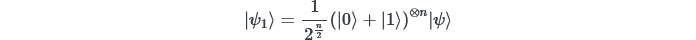

 Controlled Unitary Operations: We need to introduce the controlled unitary CUthat applies the unitary operator U on the target register only if its corresponding control bit is $|1⟩$. Since U is a unitary operator with eigenvector $|\psi⟩$ such that $U|\psi⟩ = e^{2 \pi \iota \theta}|\psi⟩$, this means:


 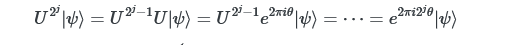

Applying all the n controlled operations $CU^{2^j}$
with $ 0 \le j \le n-1$ , and using the relation:

Screenshot 2023-08-02 at 15-21-12 Quantum Phase Estimation.png

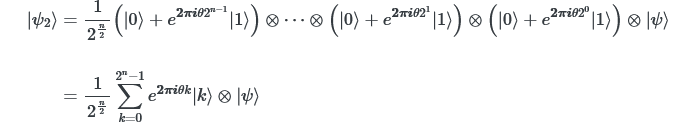

where $k$ denotes the integer representation of n-bit binary numbers.

Inverse Fourier Transform: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in the  article on [Quantum Fourier Transform and its Qiskit Implementation](https://medium.com/@_monitsharma/learn-quantum-computing-with-qiskit-quantum-fourier-transform-e27176c8f378). Recall that QFT maps an n-qubit input state$|x⟩$ into an output as:



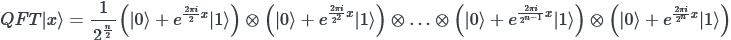

Replacing $x$ by $2^n \theta$
in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $|2^n \theta⟩$
, apply an inverse Fourier transform on the auxiliary register. Doing so, we find




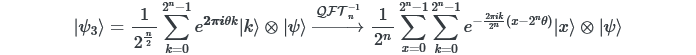

Measurement: The above expression peaks near $x = 2^n \theta$
. For the case when $2^n \theta$
is an integer, measuring in the computational basis gives the phase in the auxiliary register with high probability:



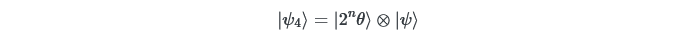

For the case when $2^n \theta$
is not an integer, it can be shown that the above expression still peaks near $ x = 2^n \theta$
with probability better than $4/\pi^2 = 40\%$

##  Example: T-gate

Let’s take a gate we know well, the T-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the T-gate adds a phase of $e^{\iota \pi/4}$
to the state $|1⟩$:


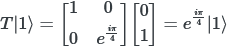




Since QPE will give us $theta$ where

Screenshot 2023-08-02 at 15-26-25 Quantum Phase Estimation.png

We expect to find:
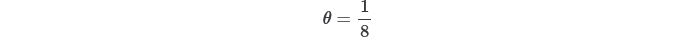

In this example we will use three qubits and obtain an exact result (not an estimation!)

## Creating the Circuit

Let's first prepare our environment:

In [2]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools and circuits
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

Now, set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as the eigenstate of the unitary operator (T).

We initialize $|\psi⟩ = |1⟩$ by applying an X gate:

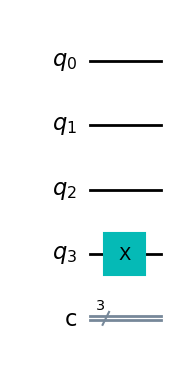

In [3]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw('mpl')

Next, we apply Hadamard gates to the counting qubits:

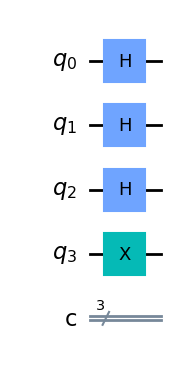

In [4]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw('mpl')

Next we perform the controlled unitary operations.



We'll use Qiskit's `PhaseGate` to create the T operation. The phase gate does the transformation

Screenshot 2023-08-02 at 15-28-22 Quantum Phase Estimation.png


 , where $\lambda$ is the angle we provide. Since we want to implement T, which performs ,


 Screenshot 2023-08-02 at 15-28-50 Quantum Phase Estimation.png


  we need to set
$\lambda = \pi/4$.



Also remember that Qiskit orders its qubits the opposite way round to the circuit diagram in the overview.

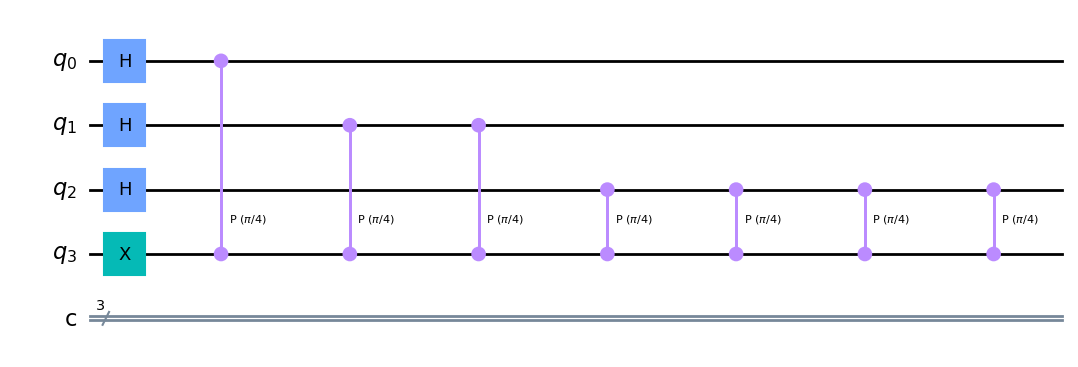

In [5]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # controlled-T
    repetitions *= 2
qpe.draw('mpl')

We apply the inverse quantum Fourier transformation to convert the state of the counting register, then measure the counting register:

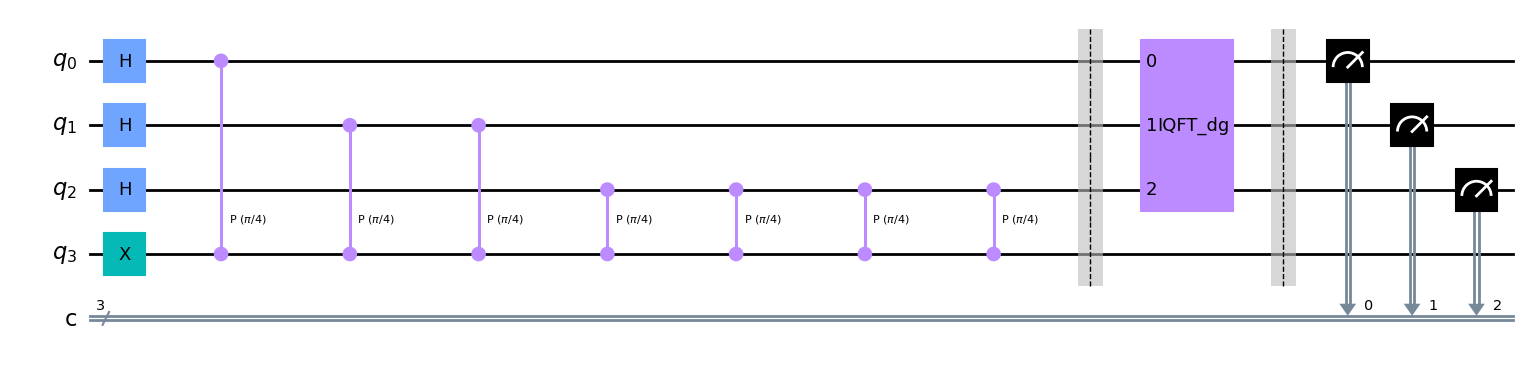

In [6]:
qpe.barrier()
# Apply inverse QFT
qpe = qpe.compose(QFT(3, inverse=True), [0,1,2])
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw('mpl')

 Results

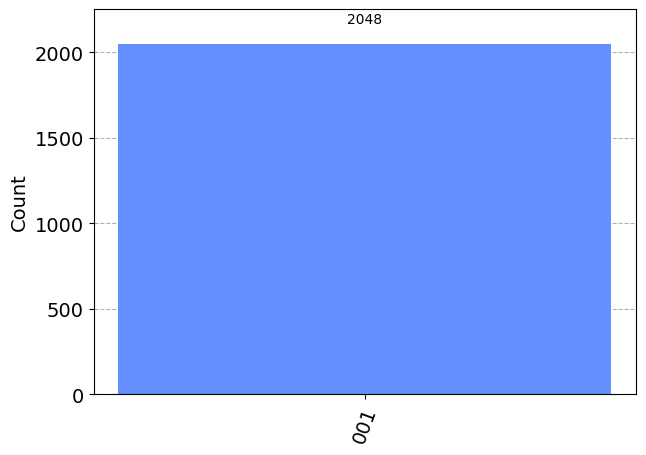

In [7]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (001) with certainty, which translates to the decimal: 1. We now need to divide our result by $2^n$ to get $\theta$
to get :


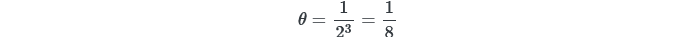



This is exactly the result we expected!

## Example: Getting More Precision

### The Problem

Instead of a T-gate, let’s use a gate with $\theta= 1/3$
.

In the cell below, we set up our circuit as we did with the last example.

We'll use Qiskit's `PhaseGate` again, which does

Screenshot 2023-08-02 at 15-28-22 Quantum Phase Estimation.png

 . Since we want to implement

Screenshot 2023-08-02 at 15-31-15 Quantum Phase Estimation.png

, we need to set
$\lambda = 2\pi/3$
.

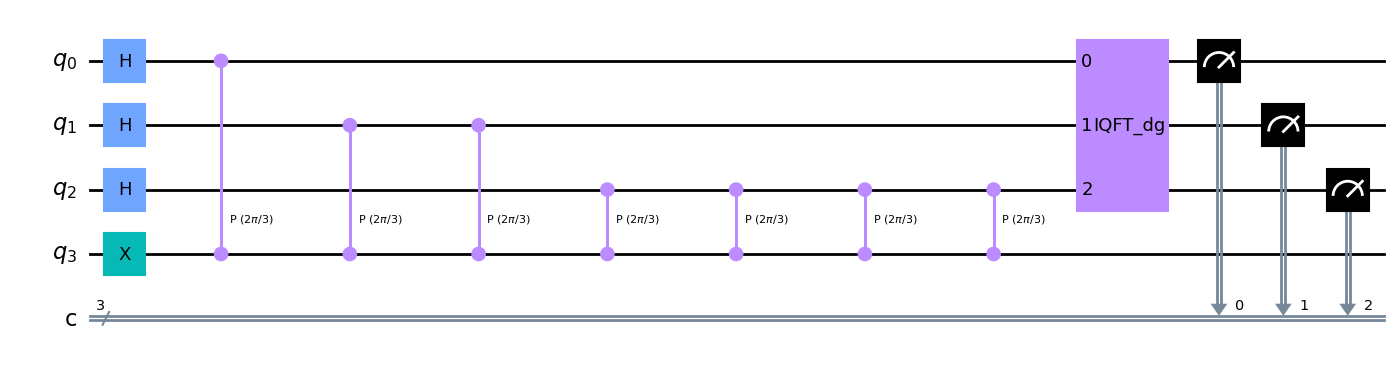

In [8]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(3, inverse=True), [0,1,2])

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw('mpl')

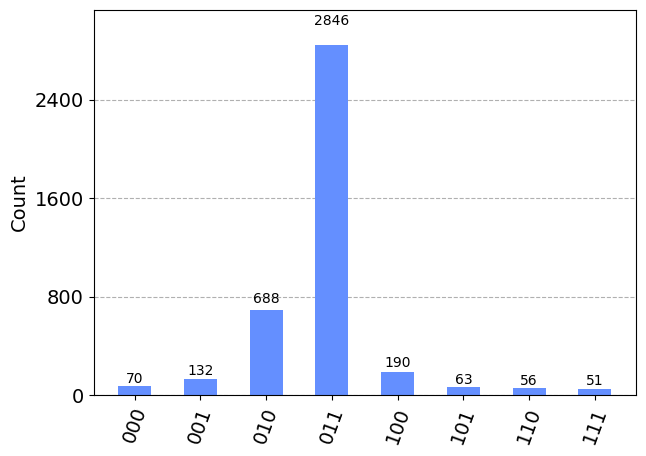

In [9]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
results = aer_sim.run(t_qpe2, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 0.33333$ , and we see our most likely results are 010(bin) = 2(dec) and 011(bin) = 3(dec). These two results would tell us that $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

The Solution

To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

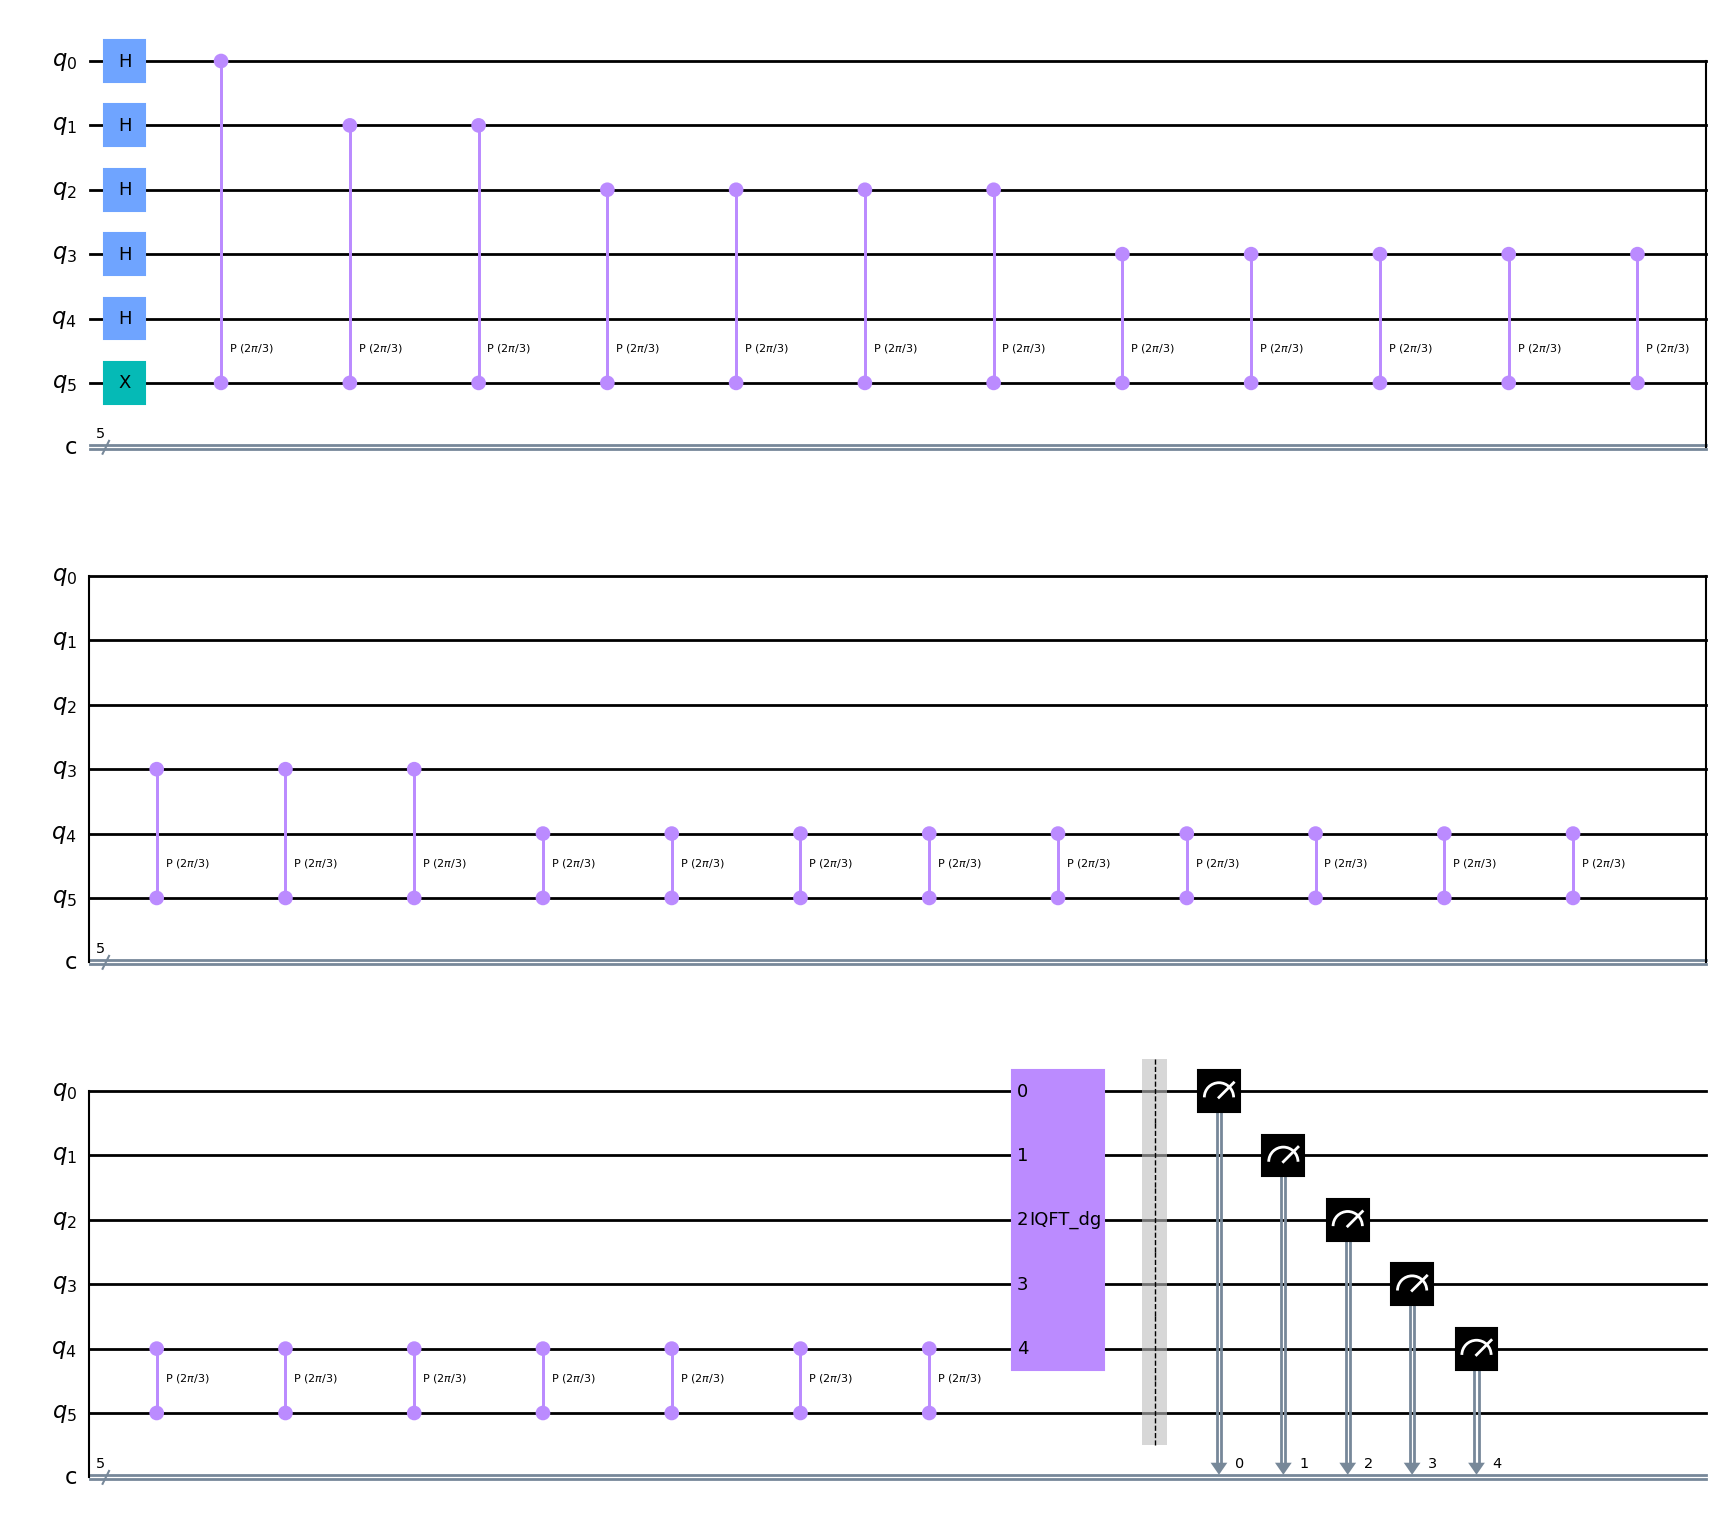

In [10]:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qpe3 = qpe3.compose(QFT(5, inverse=True), range(5))

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)

qpe3.draw('mpl')

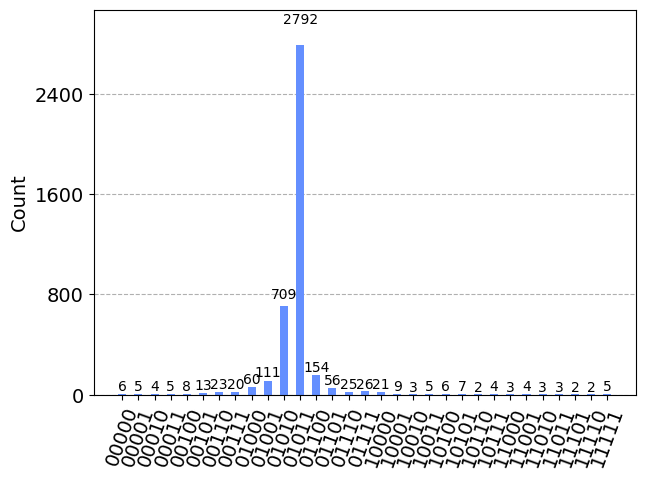

In [11]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
results = aer_sim.run(t_qpe3, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

The two most likely measurements are now 01011 (decimal 11) and 01010 (decimal 10). Measuring these results would tell us $\theta$ is:



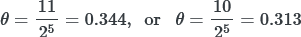



These two results differ from $\frac{1}{3}$
by 3% and 6% respectively. A much better precision!

### Experiment with Real Devices



We can run the circuit in previous section on a real device, let's remind ourselves of the circuit:

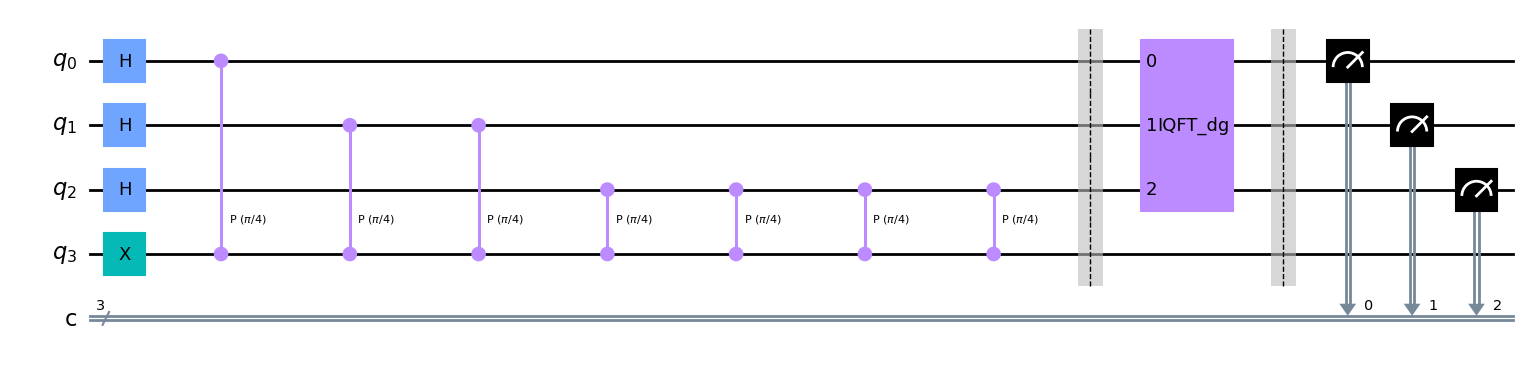

In [13]:
qpe.draw('mpl')

In [15]:
from qiskit import IBMQ
IBMQ.save_account('ENTER API TOKEN HERE')

In [16]:
from qiskit.providers.ibmq import least_busy
IBMQ.load_account()
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibm_perth


In [17]:
# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, backend, optimization_level=3)
job = backend.run(t_qpe, shots=shots)
job_monitor(job)

Job Status: job has successfully run


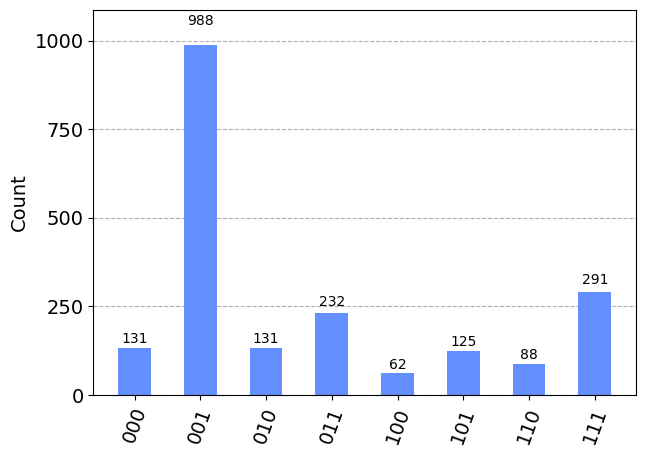

In [23]:
# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

We can hopefully see that the most likely result is 001 which is the result we would expect from the simulator. Unlike the simulator, there is a probability of measuring something other than 001, this is due to noise and gate errors in the quantum computer.

The quantum phase estimation algorithm may seem pointless, since we have to know $\theta$ to perform the controlled-U operations on our quantum computer. We will see in later chapters that it is possible to create circuits for which we don’t know $\theta$, and for which learning theta can tell us something very useful (most famously how to factor a number!)



Check the entire blog series : [Learn Quantum Computing with Qiskit](https://medium.com/@_monitsharma/list/introduction-to-quantum-computing-with-qiskit-6caba64cc007)

or visit my website for more such learning resources :

[The Quantum Classroom](https://monitsharma.github.io/)
